<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/master/11.AdvancedConcepts/CIFAR10-LRFinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers, optimizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


In [3]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


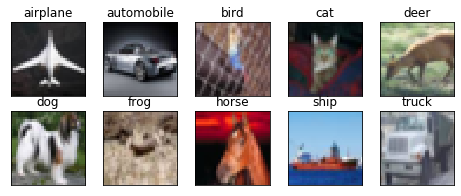

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [8]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()


print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (trainX.mean(), trainX.std(), testX.mean(), testX.std()))

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate the mean on the training dataset
datagen.fit(trainX)
#print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

# demonstrate effect on a single batch of samples
iterator = datagen.flow(trainX, trainy, batch_size=128)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

# demonstrate effect on entire training dataset
iterator = datagen.flow(trainX, trainy, batch_size=len(trainX), shuffle=False)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

Statistics train=120.708 (64.150), test=121.529 (64.061)
(128, 32, 32, 3) 0.01989002 1.0052702
(50000, 32, 32, 3) -1.6605131e-06 1.0000001


In [0]:
iterator1 = datagen.flow(testX, testy, batch_size=len(testX), shuffle=False)
batch_testX, batch_testy = iterator1.next()

X_train = batchX
X_test = batch_testX

y_train=batchy
y_test=batch_testy
                        

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [12]:
# Define the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(10, 1, 1))

model.add(AveragePooling2D(pool_size = (4,4)))
model.add(Flatten())


model.add(Activation('softmax'))




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1))`


In [38]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)       

#### Total params: 455,370

### Adding Cutout

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))



### Adding LRFinder
Reference: http://puzzlemusa.com/2018/05/14/learning-rate-finder-using-keras/

We will start training out model using a very low learning rate then exponentially increase that over iteration. In the mean time we will save our learning rate along with our loss and iteration. We will stop this procedure when loss start to jump. 

In [0]:
from keras.callbacks import Callback
import os
import keras.backend as K
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

In [32]:
lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(X_train.shape[0]/64))
model.fit_generator(datagen.flow(X_train, Y_train, batch_size = 64),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 1, 
                                 callbacks=[lr_finder],verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<__main__..., verbose=1, steps_per_epoch=781, epochs=1)`
  after removing the cwd from sys.path.


Epoch 1/1
781/781 [==============================] - 15s 19ms/step - loss: 18.8615 - acc: 0.0998


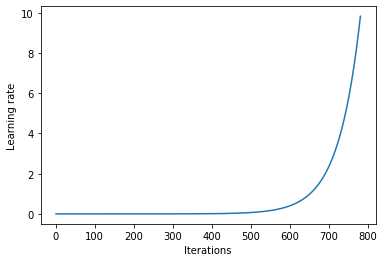

In [33]:
lr_finder.plot_lr()

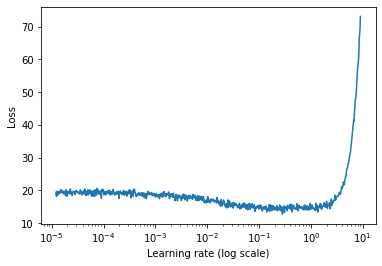

In [34]:
lr_finder.plot()

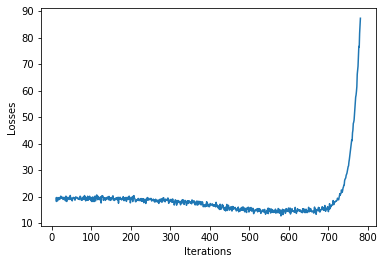

In [36]:
lr_finder.plot_loss()

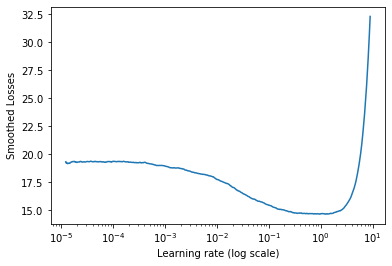

In [35]:
lr_finder.plot_smoothed_loss()

First, with low learning rates, the loss improves slowly, then training accelerates until the learning rate becomes too large and loss goes up: the training process diverges.

We need to select a point on the graph with the fastest decrease in the loss. In this example, the loss function decreases fast when the learning rate is between 0.01 and 0.1.



In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
checkpointer = ModelCheckpoint(filepath='../content/drive/My Drive/Models/AdvanceConcepts/CIFAR10_S11.h5', monitor='val_acc', mode='auto', verbose = 1, save_best_only=True)

sgd = optimizers.SGD(lr=0.01, decay=0, momentum=0.9, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (X_test, Y_test), verbose=0, callbacks=[reduce_lr])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=0, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  # This is added back by InteractiveShellApp.init_path()
